# Transactions - Data Modelling

In [1]:
import os

import joblib
import numpy as np
import pandas as pd
import skops.io as sio
from tqdm import tqdm

import helpers
from helpers import (
    CHARTS_DIR, ENCODER_MODEL_DIR, RAW_DATA_DIR, TRANSFORMED_DATA_DIR
)

## Load integrated data

In [2]:
df_transactions = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt7_integrated.parquet')
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median_income,mean_income,n_households,wellbeing_index,money_supply_millions,unemployment_rate,population_thousands,n_crimes,date,interest_rate
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,128.0,129888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1007.0,1007.0,122.0,122888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,122.0,123888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,2.000000,753.0,672.0,120.0,90000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.078282,1875.0,1126.0,180.0,338000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5


In [3]:
df_transactions.columns

Index(['township', 'building_type', 'tenure', 'floors', 'rooms', 'land_area',
       'built_up', 'price_psf', 'price', 'year', 'month', 'day', 'cpi',
       'median_income', 'mean_income', 'n_households', 'wellbeing_index',
       'money_supply_millions', 'unemployment_rate', 'population_thousands',
       'n_crimes', 'date', 'interest_rate'],
      dtype='object')

## Check for feature correlation and association

Before we begin modelling, we need to check for feature correlation and association. However, we need to determine the scale of the features first:

**Continuous data:**
1. Interval:
    - cpi
2. Ratio:
    - land_area
    - built_up
    - median_income
    - mean_income
    - wellbeing_index
    - money_supply_millions
    - unemployment_rate
    - interest_rate
    - price_psf

**Discrete data:**
1. Nominal:
    - township
    - building_type
    - tenure
2. Ordinal:
    - year
    - month
    - day
3. Ratio:
    - n_households
    - population_thousands
    - n_crimes
    - floors
    - rooms

Before selecting the appropriate correlation and association tests, we need to determine the normality of the continuous data. We will use the Shapiro-Wilk test for normality, which is provided by Scipy's `normaltest`.

In [4]:
from scipy.stats import kruskal, normaltest, pearsonr, spearmanr

In [5]:
continuous_vars = [
    'land_area',
    'built_up',
    'price_psf',
    'median_income',
    'mean_income',
    'wellbeing_index',
    'money_supply_millions',
    'unemployment_rate',
    'interest_rate'
]

for var in continuous_vars:
    normal_result = normaltest(df_transactions[var], nan_policy='omit')
    print(f"Normality test for {var}: {normal_result}")

Normality test for land_area: NormaltestResult(statistic=590870.0868928022, pvalue=0.0)
Normality test for built_up: NormaltestResult(statistic=265651.55731307523, pvalue=0.0)
Normality test for price_psf: NormaltestResult(statistic=175457.22731882718, pvalue=0.0)
Normality test for median_income: NormaltestResult(statistic=21166671.14165013, pvalue=0.0)
Normality test for mean_income: NormaltestResult(statistic=1423955.698392976, pvalue=0.0)
Normality test for wellbeing_index: NormaltestResult(statistic=58074.19249076957, pvalue=0.0)
Normality test for money_supply_millions: NormaltestResult(statistic=62418.155795693216, pvalue=0.0)
Normality test for unemployment_rate: NormaltestResult(statistic=72219.24276097854, pvalue=0.0)
Normality test for interest_rate: NormaltestResult(statistic=28612.33706469147, pvalue=0.0)


All of the continuous variables are not from normal distribution.

### Selecting the appropriate correlation and association tests

Our target variable for modelling is `price_psf`. We will check for correlation and association between `price_psf` and the other features. Let's choose the appropriate correlation and association tests for the different types of data:

**Continuous data vs price_psf:** 
1. Interval: Pearson's correlation coefficient
2. Ratio: Pearson's correlation coefficient

**Discrete data vs price_psf:**
1. Nominal: Kruskal-Wallis H-test
2. Ordinal: Spearman's rank correlation coefficient
3. Ratio: Pearson's correlation coefficient

### Continuous variables (interval and ratio) vs `price_psf`

In [6]:
target_var = 'price_psf'

for var in continuous_vars:
    pearson_result = pearsonr(df_transactions[var], df_transactions[target_var])
    print(f"Pearson correlation test for {var}: {pearson_result}")

Pearson correlation test for land_area: PearsonRResult(statistic=-0.0003414081028704389, pvalue=0.8698648254733987)
Pearson correlation test for built_up: PearsonRResult(statistic=0.27575433819443673, pvalue=0.0)
Pearson correlation test for price_psf: PearsonRResult(statistic=0.9999999999999937, pvalue=0.0)
Pearson correlation test for median_income: PearsonRResult(statistic=0.46978636197555945, pvalue=0.0)
Pearson correlation test for mean_income: PearsonRResult(statistic=0.47441434743219024, pvalue=0.0)
Pearson correlation test for wellbeing_index: PearsonRResult(statistic=0.4682907609353156, pvalue=0.0)
Pearson correlation test for money_supply_millions: PearsonRResult(statistic=0.4708744423231275, pvalue=0.0)
Pearson correlation test for unemployment_rate: PearsonRResult(statistic=0.054053978128958124, pvalue=1.4904119594671785e-148)
Pearson correlation test for interest_rate: PearsonRResult(statistic=-0.26080401092289723, pvalue=0.0)


For Pearson test (DV: continuous, IV: continuous), the null hypothesis H0 is that the two samples are uncorrelated.

Having p-values < 0.05 means that `built_up`, `median_income`, `mean_income`, `wellbeing_index`, `money_supply_millions`, `unemployment_rate` and `interest_rate` are correlated with `price_psf`.

Surprisingly, `land_area` is not correlated with `price_psf` as the p-value is > 0.05, thus we were unable to reject the null hypothesis. `land_area` is uncorrelated with `price_psf`. Let's check with plot.

<Axes: title={'center': 'Land Area vs Price per Square Feet'}, xlabel='land_area', ylabel='price_psf'>

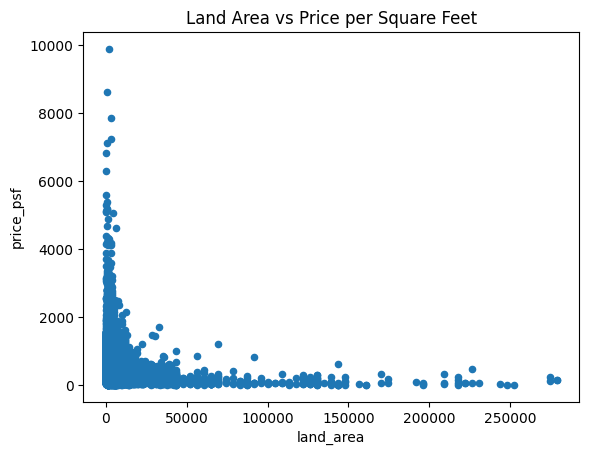

In [7]:
df_transactions[['price_psf', 'land_area']].plot(
    kind='scatter',
    x='land_area',
    y='price_psf',
    title='Land Area vs Price per Square Feet'
)

Based on the plot above, we can see that there is no correlation between `land_area` and `price_psf`.

### Discrete variables (nominal) vs `price_psf`

In [8]:
nominal_vars = ['township', 'building_type', 'tenure']

for var in nominal_vars:
    kruskal_result = kruskal(*df_transactions[[var, target_var]].groupby(var, observed=True)[target_var].apply(list), nan_policy='omit')
    print(f"Kruskal-Wallis result for {var} and {target_var}: {kruskal_result}")

Kruskal-Wallis result for township and price_psf: KruskalResult(statistic=143840.41840357677, pvalue=0.0)
Kruskal-Wallis result for building_type and price_psf: KruskalResult(statistic=71844.01611948658, pvalue=0.0)
Kruskal-Wallis result for tenure and price_psf: KruskalResult(statistic=17776.816993317563, pvalue=0.0)


For Kruskal-Wallis test (DV: continuous, IV: nominal), the null hypothesis H0 is that the population median of all of the groups are equal (thus no association as different groups has the similar population median), while the alternative hypothesis H1 is that the population median of all of the groups are not equal (thus has association as different groups will have different population median).

Since the computed p-values < 0.05 therefore we reject the null hypothesis H0 and conclude that there is association between the nominal variables `township`, `building_type` and `tenure` against `price_psf`.

### Discrete variables (ordinal) vs `price_psf`

In [9]:
ordinal_vars = ['year', 'month', 'day']

for var in ordinal_vars:
    spearman_result = spearmanr(df_transactions[var], df_transactions[target_var], nan_policy='omit')
    print(f"Spearman result for {var} and {target_var}: {spearman_result}")

Spearman result for year and price_psf: SignificanceResult(statistic=0.5955678854090415, pvalue=0.0)
Spearman result for month and price_psf: SignificanceResult(statistic=0.05417040095458992, pvalue=3.471348050926613e-149)
Spearman result for day and price_psf: SignificanceResult(statistic=0.006744450409726356, pvalue=0.0012101790242186501)


For Spearman rank test (DV: continuous, IV: ordinal), the null hypothesis H0 is that there is no correlation between variables, while the alternative hypothesis H1 is that there is a correlation between variables.

Since the computed p-values are close to 0.0 (less than 0.05) therefore we reject the null hypothesis H0 and conclude that there is a correlation between variables. Thus, `year`, `month` and `day` has an impact on the `price_psf`.

### Discrete variables (ratio) vs `price_psf`

In [10]:
ratio_vars = ['n_households', 'population_thousands', 'n_crimes', 'floors', 'rooms']

for var in ratio_vars:
    pearson_result = pearsonr(df_transactions[var], df_transactions[target_var])
    print(f"Pearson correlation test for {var}: {pearson_result}")

Pearson correlation test for n_households: PearsonRResult(statistic=0.4585270925268039, pvalue=0.0)
Pearson correlation test for population_thousands: PearsonRResult(statistic=0.44512550413939594, pvalue=0.0)
Pearson correlation test for n_crimes: PearsonRResult(statistic=-0.46551192428577126, pvalue=0.0)
Pearson correlation test for floors: PearsonRResult(statistic=0.0797170397562012, pvalue=3.51e-321)
Pearson correlation test for rooms: PearsonRResult(statistic=0.05268622045361267, pvalue=3.202016933693272e-141)


However, the Spearman rank test (DV: continuous, IV: ratio) shows otherwise. Similarly, the null hypothesis H0 is that there is no correlation between variables, while the alternative hypothesis H1 is that there is a correlation between variables.

Since the computed p-values are close to 0.0 (less than 0.05) therefore we reject the null hypothesis H0 and conclude that there is a correlation between the ratio variables `n_households`, `population_thousands`, `n_crimes`, `floors`, `rooms` on `price_psf`.

## Data splitting

In [21]:
df_transactions = df_transactions.sort_values(by=['date'])
df_transactions.head()

,township,building_type,tenure,floors,rooms,land_area,built_up,price_psf,price,year,...,median_income,mean_income,n_households,wellbeing_index,money_supply_millions,unemployment_rate,population_thousands,n_crimes,date,interest_rate
34996,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,128.0,129888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34997,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1007.0,1007.0,122.0,122888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-01,5.5
34998,SENTOSA COURT,APARTMENT,LEASEHOLD,1.0,3.000000,1015.0,1015.0,122.0,123888.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
34999,BANDAR BARU SRI PETALING,TERRACE HOUSE - INTERMEDIATE,LEASEHOLD,2.0,2.000000,753.0,672.0,120.0,90000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5
35000,BUKIT BANDARAYA,TERRACE HOUSE - INTERMEDIATE,FREEHOLD,1.0,3.078282,1875.0,1126.0,180.0,338000.0,2000.0,...,3006.666667,4379.74,299566.666667,100.0,458363.1,3.0,1416.0,8770.0,2000-01-02,5.5


In [24]:
df_train = df_transactions.query('year <= 2020')
df_train['year'].value_counts().sort_index()


year
2000.0     6470
2001.0     6494
2002.0     7547
2003.0     8379
2004.0    10449
2005.0     9382
2006.0     8990
2007.0    11603
2008.0    11943
2009.0    13817
2010.0    13409
2011.0    14156
2012.0    12561
2013.0    14271
2014.0    12335
2015.0     9877
2016.0     8573
2017.0     9371
2018.0     8758
2019.0     7388
2020.0     6775
Name: count, dtype: int64

In [25]:
df_test = df_transactions.query('year >= 2021')
df_test['year'].value_counts().sort_index()

year
2021.0    7492
2022.0    8136
2023.0    2098
Name: count, dtype: int64

## Modelling with traditional time series methods

In [75]:
df_yearly_price_psf_train = df_train[['year', 'price_psf']]
df_monthly_price_psf_train = df_train[['year', 'month', 'price_psf']]
df_daily_price_psf_train = df_train[['date', 'price_psf']]

<Axes: title={'center': 'Mean and Median Price per Square Feet per Year'}, xlabel='year'>

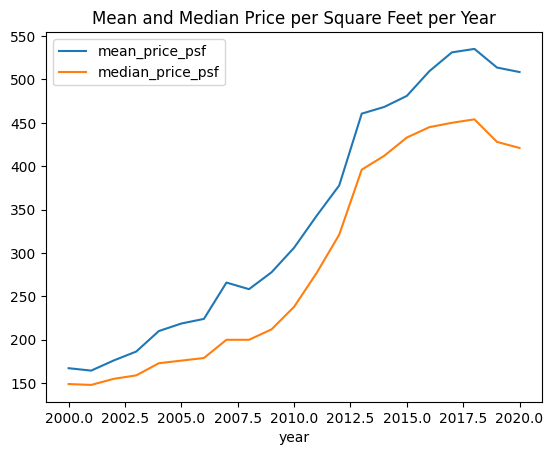

In [57]:
mean_yearly_price_psf = df_yearly_price_psf_train.groupby('year').mean()
median_yearly_price_psf = df_yearly_price_psf_train.groupby('year').median()

df_price_psf_per_year = pd.concat([mean_yearly_price_psf, median_yearly_price_psf], axis=1)
df_price_psf_per_year.columns = ['mean_price_psf', 'median_price_psf']

df_price_psf_per_year.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Year',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

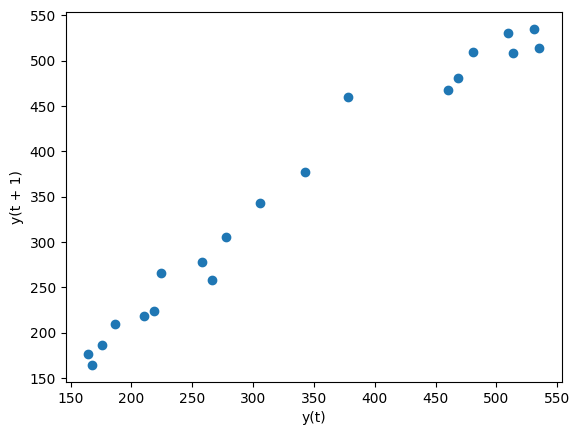

In [113]:
from pandas.plotting import autocorrelation_plot, lag_plot

lag_plot(mean_yearly_price_psf['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

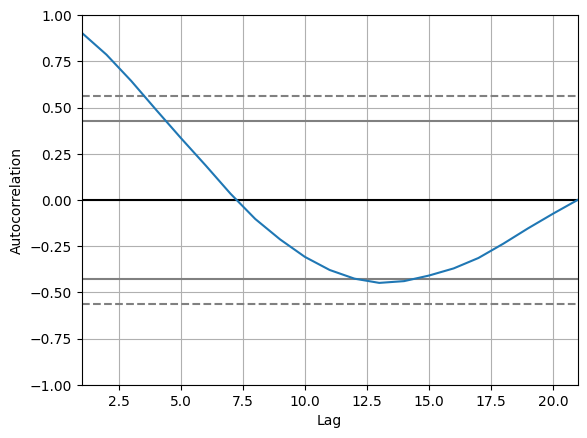

In [114]:
autocorrelation_plot(mean_yearly_price_psf['price_psf'])

Number of days from 2000 to 2020: 7665
Length of grouped dataframe: 7093


<Axes: title={'center': 'Mean and Median Price per Square Feet per Day'}, xlabel='date'>

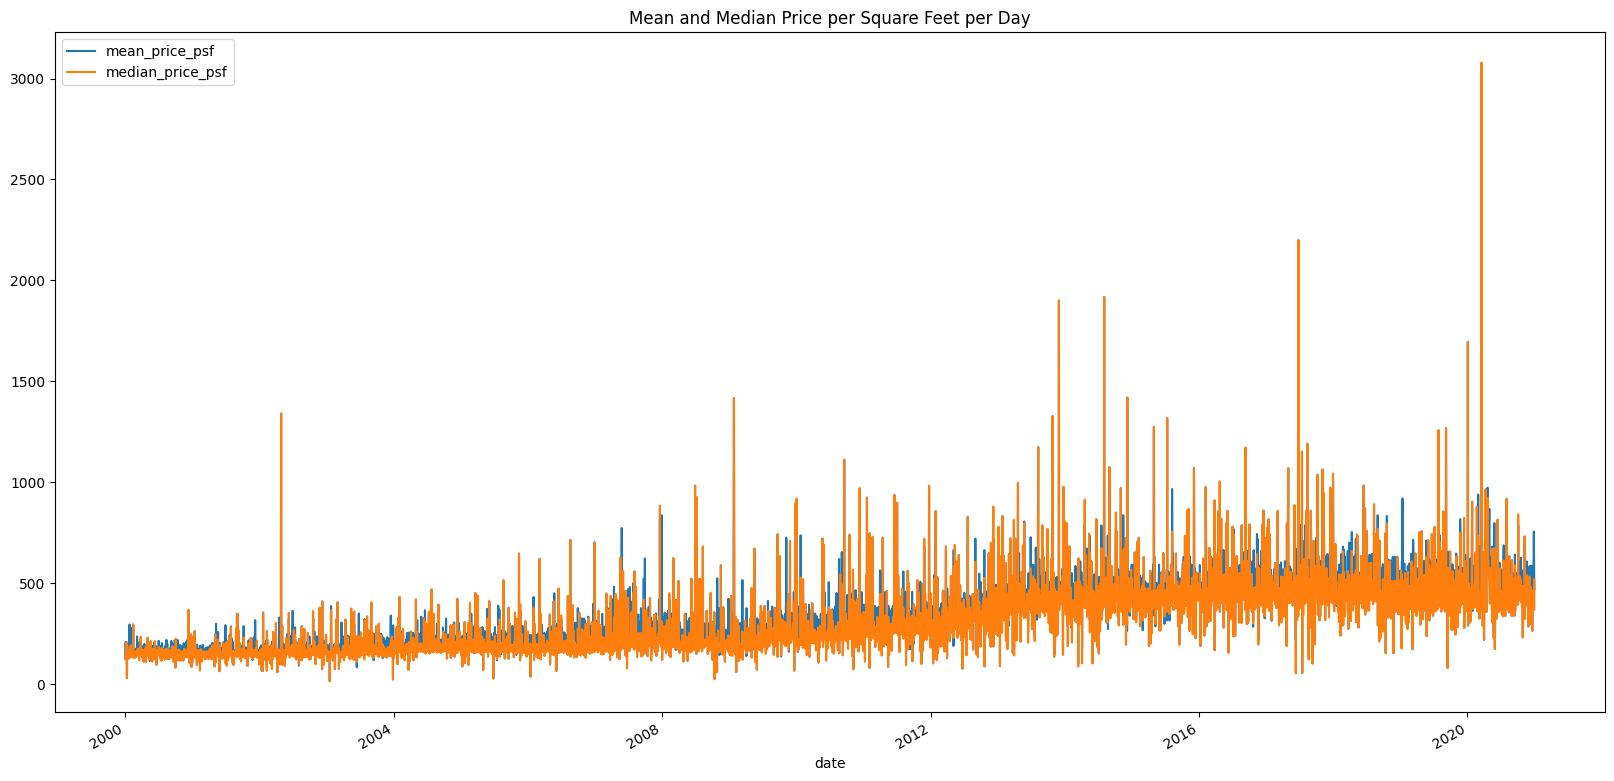

In [70]:
mean_daily_price_psf = df_daily_price_psf_train.groupby('date').mean()
median_daily_price_psf = df_daily_price_psf_train.groupby('date').median()

df_price_psf_per_day = pd.concat([mean_daily_price_psf, median_daily_price_psf], axis=1)
df_price_psf_per_day.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of days from 2000 to 2020: {365 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_day)}')

df_price_psf_per_day.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Day',
    figsize=(20, 10)
)

There are days with no transactions.

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

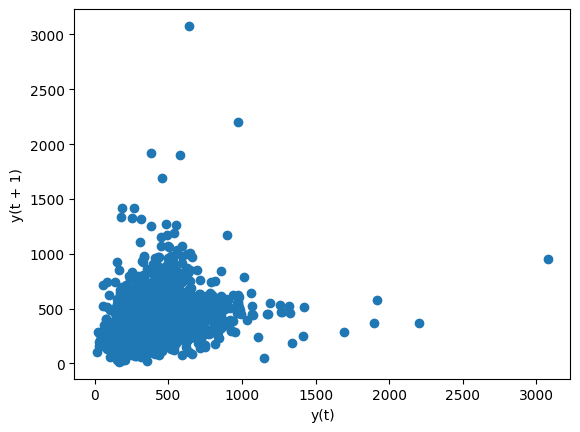

In [115]:
lag_plot(mean_daily_price_psf['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

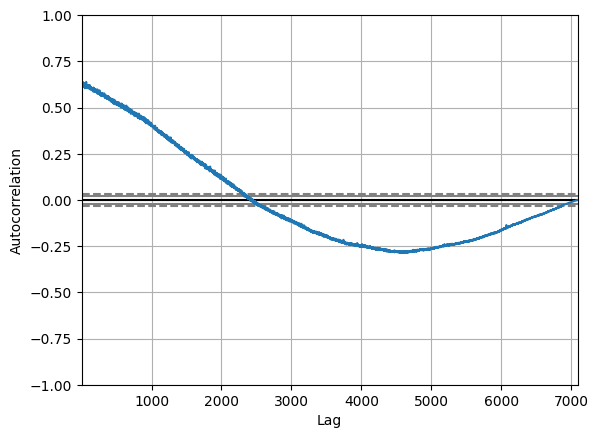

In [116]:
autocorrelation_plot(mean_daily_price_psf['price_psf'])

In [105]:
df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1)) 
df_monthly_price_psf_train.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_19076\447924927.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monthly_price_psf_train['year_month'] = pd.to_datetime(df_monthly_price_psf_train[['year', 'month']].assign(day=1))


,year,month,price_psf,year_month
34996,2000.0,1.0,128.0,2000-01-01
34997,2000.0,1.0,122.0,2000-01-01
34998,2000.0,1.0,122.0,2000-01-01
34999,2000.0,1.0,120.0,2000-01-01
35000,2000.0,1.0,180.0,2000-01-01


Number of months from 2000 to 2020: 252
Length of grouped dataframe: 252


<Axes: title={'center': 'Mean and Median Price per Square Feet per Month'}, xlabel='year_month'>

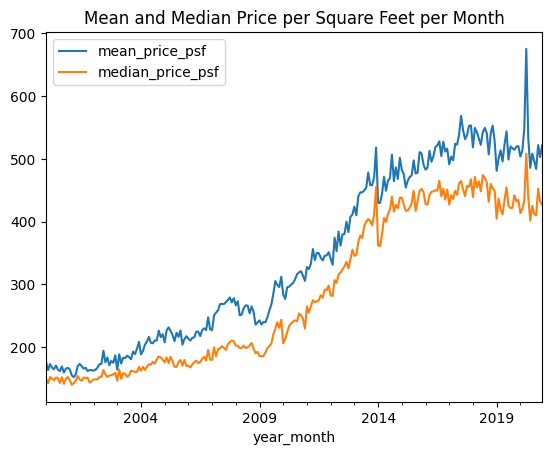

In [107]:
mean_monthly_price_psf = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').mean()
median_monthly_price_psf = df_monthly_price_psf_train[['year_month', 'price_psf']].groupby('year_month').median()

df_price_psf_per_month = pd.concat([mean_monthly_price_psf, median_monthly_price_psf], axis=1)
df_price_psf_per_month.columns = ['mean_price_psf', 'median_price_psf']

print(f'Number of months from 2000 to 2020: {12 * 21}')
print(f'Length of grouped dataframe: {len(df_price_psf_per_month)}')

df_price_psf_per_month.plot(
    kind='line',
    title='Mean and Median Price per Square Feet per Month',
)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

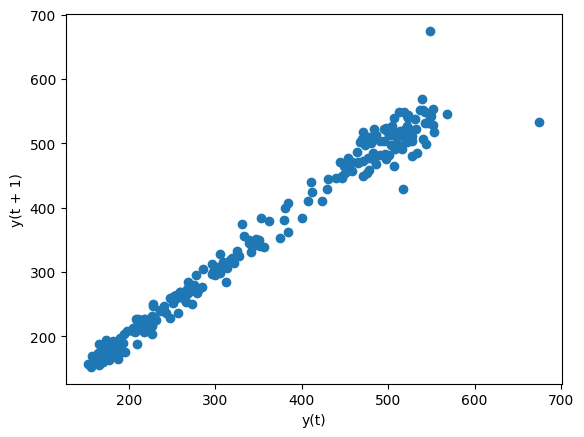

In [117]:
lag_plot(mean_monthly_price_psf['price_psf'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

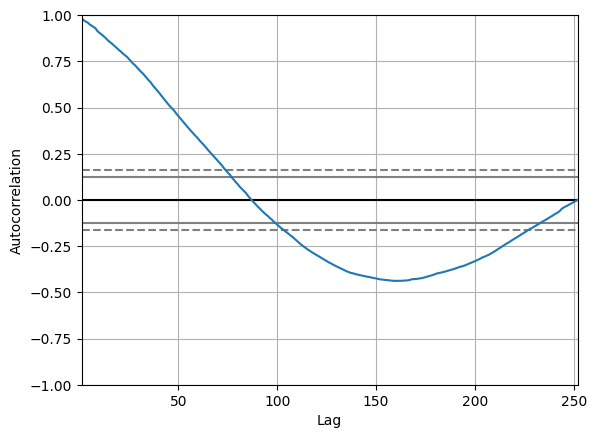

In [118]:
autocorrelation_plot(mean_monthly_price_psf['price_psf'])

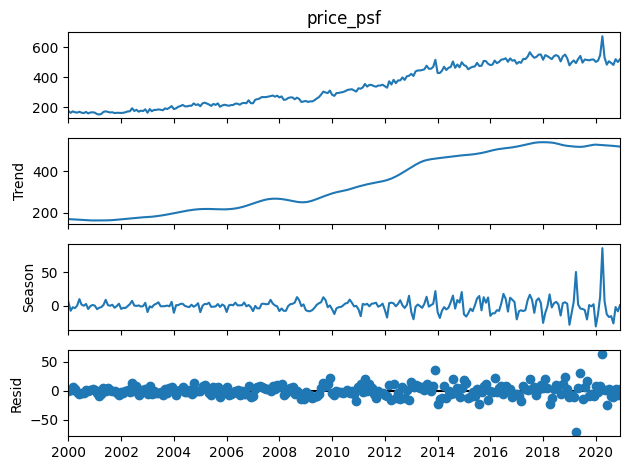

In [110]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

mean_price_psf_stl = STL(mean_monthly_price_psf['price_psf'], period=12).fit()
mean_price_psf_stl.plot()
plt.show()

Based on STL decomposition, there are increasing trend and seasonality:
1. The trend is flat until 2004, where it started to increase steadily until 2018. Then it plateaued until 2020.
2. The seasonality is flat until 2008, where it started to increase slightly at 2012. Seasonality spiked at 2019 onwards.
3. No pattern is spotted for residuals.

Moving forward, we will use monthly data for forecasting.

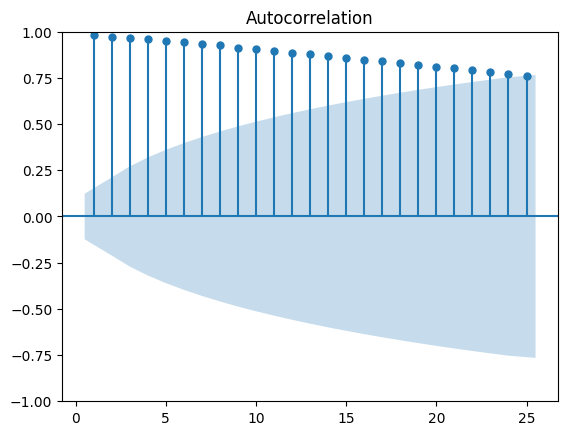

In [121]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(mean_monthly_price_psf['price_psf'], zero=False)
plt.show()

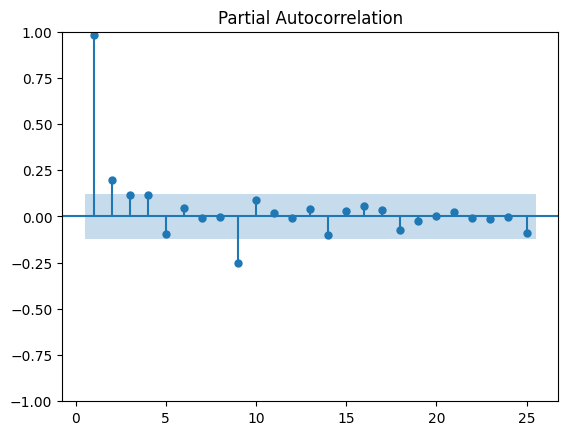

In [122]:
plot_pacf(mean_monthly_price_psf['price_psf'], zero=False)
plt.show()

We can use AR(2) to model this time series.

## Encoding for ML-based modelling

Based on the correlation and association tests, the `land_area` have to be dropped as it is uncorrelated with `price_psf`.

But let's encode the features with one hot encoder first before dropping `land_area`.

In [11]:
df_transactions[df_transactions.columns[:12]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   township       230274 non-null  category
 1   building_type  230274 non-null  category
 2   tenure         230274 non-null  category
 3   floors         230274 non-null  float64 
 4   rooms          230274 non-null  float64 
 5   land_area      230274 non-null  float64 
 6   built_up       230274 non-null  float64 
 7   price_psf      230274 non-null  float64 
 8   price          230274 non-null  float64 
 9   year           230274 non-null  float64 
 10  month          230274 non-null  float64 
 11  day            230274 non-null  float64 
dtypes: category(3), float64(9)
memory usage: 18.5 MB


In [12]:
encoder_path = ENCODER_MODEL_DIR / 'one_hot_encoder_township_building_type_tenure.joblib'

if os.path.exists(encoder_path):
    ohe = joblib.load(encoder_path)
else:
    raise Exception(f'Encoder not found at {encoder_path}')

df_encoded = ohe.transform(df_transactions[df_transactions.columns[:12]])
df_encoded.info()

d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
d:\Repos\GitHub\time-series-house-price-forecasting\venv\Lib\site-packages\category_encoders\utils.py:50: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)


<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Columns: 1905 entries, township_BANDAR BARU SRI PETALING to day
dtypes: float64(9), int64(1896)
memory usage: 3.3 GB


In [13]:
df_transactions = pd.concat([df_transactions[df_transactions.columns[12:]], df_encoded], axis=1)
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Columns: 1916 entries, cpi to day
dtypes: datetime64[ns](1), float64(19), int64(1896)
memory usage: 3.3 GB


In [14]:
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt8_integrated_encoded.parquet')

In [15]:
df_transactions = df_transactions.drop(columns=['land_area'])
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230274 entries, 34996 to 265269
Columns: 1915 entries, cpi to day
dtypes: datetime64[ns](1), float64(18), int64(1896)
memory usage: 3.3 GB


In [16]:
df_transactions.to_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt9_integrated_encoded_dropped.parquet')

## Modelling

<Axes: title={'center': 'Price per Square Feet vs Year'}, xlabel='year', ylabel='price_psf'>

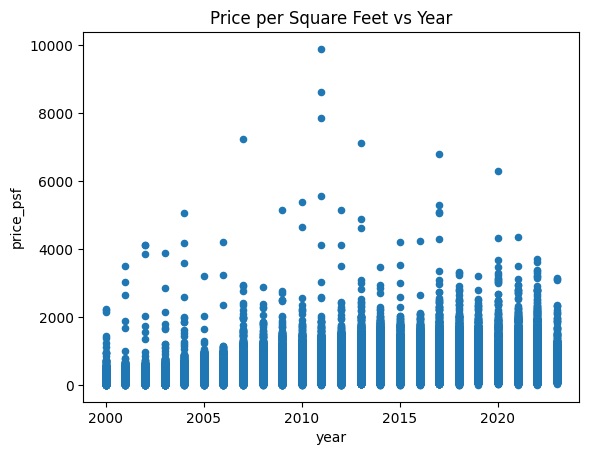

In [17]:
df_transactions.plot(
    kind='scatter',
    x='year',
    y='price_psf',
    title='Price per Square Feet vs Year'
)